In [137]:
import numpy as np
import pandas as pd

import tqdm
from tqdm import tqdm_notebook

from functools import reduce

from matplotlib import pyplot as plt
import matplotlib
%pylab inline

import ast

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords

import gensim
from gensim.models import KeyedVectors

Populating the interactive namespace from numpy and matplotlib


In [42]:
train_ds, test_ds = pd.read_csv('train_step7_mytokens.csv', encoding ='utf-8'), pd.read_csv('test_step7_mytokens.csv', encoding ='utf-8')

C:\Users\PDudukin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('ruwikiruscorpora_0_300_20.bin',binary=True)

In [8]:
pos = list(['_NOUN', '_ADJ', '_VERB', '_ADV', '_INTJ', '_ADP', '_PART', '_NUM', '_DET', '_PRON'])
for key in tqdm_notebook(range(len(w2v.vocab.keys())), total=len(w2v.vocab.keys()), desc= ''):
    for p in pos:
        if key.endswith(p):
            repl = key.replace(p,'')
            #print(repl)
    if repl not in w2v.vocab.keys():
        w2v.vocab[repl] = w2v.vocab.pop(key)
    else:
        pass

In [9]:
len(w2v.vocab)

392339

In [45]:
pos_list = []
for elt in w2v.vocab.keys():
    pos = elt.split('_')[1]
    #if pos not in pos_list:
    pos_list.append(pos)

In [48]:
from collections import Counter
pos_dict = dict(Counter(pos_list)) 

In [49]:
pos_dict

{'ADJ': 51258,
 'ADP': 111,
 'ADV': 6152,
 'CCONJ': 60,
 'DET': 43,
 'INTJ': 340,
 'NOUN': 311181,
 'NUM': 60,
 'PART': 89,
 'PRON': 31,
 'VERB': 23014}

In [41]:
num = 0
num_def = 20

for ind, elt in enumerate(w2v.vocab.keys()):
    #print(elt.split('_')[1])
    if elt.split('_')[1] == 'PRON' and num<num_def:
        print(elt)
        num += 1
        
# INTJ - междометие


кто-либо_PRON
каждый_PRON
свое_PRON
прочее_PRON
кой-что_PRON
сие_PRON
кто-то_PRON
всякий_PRON
что-либо_PRON
никто_PRON
нечто_PRON
что-нибудь_PRON
кое-кто_PRON
нечего_PRON
некоторые_PRON
оно_PRON
кой-кто_PRON
се_PRON
всякая_PRON
многие_PRON


In [94]:
GetFlatList(ast.literal_eval(train_ds.list_ntokens_p[0]))

['в',
 'отличие',
 'от',
 'рыба',
 'земноводный',
 'и',
 'пресмыкаться',
 'уже',
 'иметь',
 'два',
 'круг',
 'кровообращение',
 'и',
 'сердце',
 'у',
 'они',
 'трёхкамерный',
 'единственный',
 'современный',
 'рептилия',
 'иметь',
 'хотя',
 'и',
 'неполноценный',
 'но',
 'уже',
 'четырёхкамерный',
 'сердце',
 'крокодилы',
 'считаться',
 'что',
 'впервые',
 'четырёхкамерный',
 'сердце',
 'появиться',
 'у',
 'примитивный',
 'архозавр',
 'и',
 'развитый',
 'синапсидов',
 'в',
 'дальнейший',
 'такой',
 'строение',
 'сердце',
 'унаследовать',
 'прямая',
 'потомок',
 'динозавр',
 'птица',
 'и',
 'потомок',
 'примитивный',
 'млекопитающее',
 'современный',
 'млекопитающие']

In [56]:
def GetFlatList(list_of_lists):
    return reduce(lambda x,y: x+y, list_of_lists)

In [131]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на', 
                   'a','б','в','г','д','е','ё','ж','з','и',
                   'й','к','л','м','н','о','п','р','с','т',
                   'у','ф','х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я'])

set_pos_list = list(set(pos_list))


d_init = dict(Counter(list(set_pos_list)))
for key in d_init:
    d_init[key] -= 1
            
labels = list(d_init.keys())
labels.insert(0, 'paragraph_id')
labels.insert(1, 'question_id')

for name, df in [('train', train_ds), ('test', test_ds)]: 
    num_lists = []
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= name + ' POS num'):
        
        num_list = []
        
        #clean_token_par = [x for x in GetFlatList(ast.literal_eval(train_ds.loc[index, 'list_ntokens_p'])) if (x not in stop_words and not x.isdigit())]
        clean_token_que = [x for x in GetFlatList(ast.literal_eval(train_ds.loc[index, 'list_ntokens_q'])) if (x not in stop_words and not x.isdigit())]
        
        d = d_init.copy()

        for word in clean_token_que:
            for pos_ind, pos in zip(range(len(set_pos_list)), list(set_pos_list)):
                if word+'_'+pos in w2v.vocab.keys():
                    d[pos] +=1

        num_list = list(d.values())
        num_list.insert(0, df.loc[index, 'paragraph_id'])
        num_list.insert(1, df.loc[index, 'question_id'])

        num_lists.append(num_list)
    
    dfnum_list = pd.DataFrame(num_lists, columns = labels)

    if name=='train':
        train_ds = train_ds.merge(dfnum_list, how = 'left', on = ['paragraph_id', 'question_id'])
    else:
        test_ds = test_ds.merge(dfnum_list, how = 'left', on = ['paragraph_id', 'question_id'])


In [134]:
train_ds.head(20)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,paragraph_id,question_id,paragraph,question,target,list_ntokens_p,list_ntokens_q,...,ADJ,INTJ,ADP,PRON,NUM,ADV,CCONJ,DET,NOUN,VERB
0,0,0,0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0,"[['в', 'отличие', 'от', 'рыба', 'земноводный',...","[['с', 'какой', 'год', 'русский', 'царство', '...",...,2,0,0,0,0,0,0,0,10,0
1,1,1,1,7414,19164,В 1049 году Балдуину V удалось отнять у Герман...,Кто упомянул о его первых разногласиях со Штей...,0.0,"[['в', '1049', 'год', 'балдуин', 'v', 'удаться...","[['кто', 'упомянуть', 'о', 'он', 'один', 'разн...",...,4,0,1,0,0,1,0,0,11,2
2,2,2,2,6744,39767,Стремление достичь предельных значений ёмкости...,Как называется имеющая мировое значение эпоха ...,0.0,"[['стремление', 'достигнуть', 'предельный', 'з...","[['как', 'называться', 'иметь', 'мировой', 'зн...",...,3,0,0,0,0,0,0,0,9,4
3,3,3,3,7300,36318,Первый практически пригодный двухтактный газов...,Что усугублялось из-за международного давления...,0.0,"[['один', 'практически', 'пригодный', 'двухтак...","[['что', 'усугубляться', 'из-за', 'международн...",...,1,0,1,0,0,0,0,0,6,1
4,4,4,4,7077,41534,Требуя от художника углубленного изучения изоб...,Какой характер носят пророчества Леонардо да В...,0.0,"[['требовать', 'от', 'художник', 'углублённый'...","[['какой', 'характер', 'носить', 'пророчество'...",...,0,0,0,0,0,0,0,0,4,1
5,5,5,5,3559,62585,Белки — высокомолекулярные органические вещест...,Какие действия предприняла подводная лодка Чер...,0.0,"[['белка', 'высокомолекулярный', 'органический...","[['какой', 'действие', 'предпринять', 'подводн...",...,1,0,0,0,0,0,0,0,9,0
6,6,6,6,4350,3730,Прайсинговые методы — в основе лежит принцип и...,"Как называют остановки, до которых и на которы...",0.0,"[['прайсинговый', 'метод', 'в', 'основа', 'леж...","[['как', 'называть', 'остановка', 'до', 'котор...",...,1,0,0,0,0,0,0,0,2,2
7,7,7,7,8012,86629,Применяли изначально для определения близкород...,Какой признак киевский монах Нестор-летописец ...,1.0,"[['применять', 'изначально', 'для', 'определен...","[['какой', 'признак', 'киевский', 'монах', 'не...",...,1,0,0,0,0,0,0,0,3,1
8,8,8,8,3634,69421,Успешная конверсия по-разному определяется гру...,"Чтобы понять, по какому рекламному каналу приш...",1.0,"[['успешный', 'конверсия', 'по-разному', 'опре...","[['чтобы', 'понять', 'по', 'какой', 'рекламный...",...,2,0,0,0,0,0,0,0,5,1
9,9,9,9,4350,27335,Прайсинговые методы — в основе лежит принцип и...,Урожайность сои в каких странах почти не отлич...,0.0,"[['прайсинговый', 'метод', 'в', 'основа', 'леж...","[['урожайность', 'соя', 'в', 'какой', 'страна'...",...,0,0,0,0,0,0,0,0,6,1


In [135]:
# df - train dataset;
# variable = переменная
# variable_title - название переменной на графике
def PlotHistByTarget(variable, variable_title, min_x, max_x, df, df_title): 
    print('Histogram for '+ variable_title)
    
    print(DescStatsByTarget(variable, variable_title, df, df_title))
    
    plt.style.use('seaborn-deep')
    
    if df_title == 'train':
        hist_df = pd.DataFrame({'target':df['target'],variable_title:variable})
        pyplot.hist([hist_df[hist_df['target']==0][variable_title].values,hist_df[hist_df['target']==1][variable_title].values], 
                bins = 100, 
                alpha = 0.5, 
                label=['target: 0','target: 1'], 
                color = ['r','b'])
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
    else:
        hist_df = pd.DataFrame({variable_title:variable})
        pyplot.hist(hist_df[variable_title].values, 
                bins = 100, 
                alpha = 0.5, 
                label = 'test dataset',
                color = 'g')
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
        
def DescStatsByTarget(variable, variable_title, df, df_title):
    
    if df_title == 'train':
        dft = pd.DataFrame({'target':df['target'],variable_title:variable})

        x = dft[dft['target']==0][variable_title].values
        dfx = pd.DataFrame({'target: 0':x})

        count0 = len(x)
        mean0 = round(np.mean(x),6)
        std0 = round(np.std(x),6)
        min0 = round(np.min(x),6)
        median0 = round(np.median(x),6)
        max0 = round(np.max(x),6)

        y = dft[dft['target']==1][variable_title].values
        dfy = pd.DataFrame({'target: 1':y})

        count1 = len(y)
        mean1 = round(np.mean(y),6)
        std1 = round(np.std(y),6)
        min1 = round(np.min(y),6)
        median1 = round(np.median(y),6)
        max1 = round(np.max(y),6)

        df_desc = pd.DataFrame([[count0, mean0, std0, min0, median0, max0],
                            [count1, mean1, std1, min1, median1, max1]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (target: 0)',variable_title+' (target: 1)'])
    else:
        
        dft = pd.DataFrame({variable_title:variable})

        x = dft[variable_title].values
        
        count = len(x)
        mean = round(np.mean(x),6)
        std = round(np.std(x),6)
        min = round(np.min(x),6)
        median = round(np.median(x),6)
        max = round(np.max(x),6)

        df_desc = pd.DataFrame([[count, mean, std, min, median, max]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (test)'])
    
    return df_desc

Histogram for ADV
                 count      mean       std  min  median  max
ADV (target: 0)  85361  0.346950  0.670299    0     0.0    7
ADV (target: 1)  34037  0.197168  0.453684    0     0.0    7


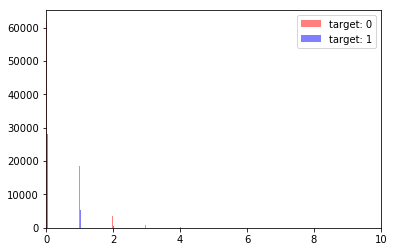

Histogram for ADV
            count      mean       std  min  median  max
ADV (test)  74302  0.305025  0.620621    0     0.0    7


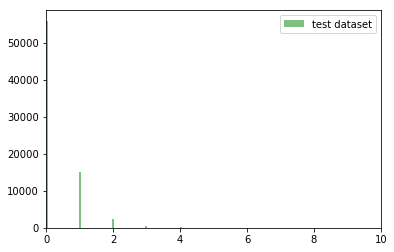

In [145]:
col = 'ADV'
PlotHistByTarget(train_ds[col], col, 0, 10, train_ds, 'train')
PlotHistByTarget(test_ds[col], col, 0, 10, test_ds, 'test')

In [149]:
def longestSubstringFinder(string1, string2):
    answer = ""
    len1, len2 = len(string1), len(string2)
    for i in range(len1):
        match = ""
        for j in range(len2):
            if (i + j < len1 and string1[i + j] == string2[j]):
                match += string2[j]
            else:
                if (len(match) > len(answer)): answer = match
                match = ""
    return answer

In [150]:
' '.join(clean_token_par)

'применять изначально определение близкородственный группа который называть также племя библейский литература роды который делиться колено дальнейший особенно появление государственный образование слово стать приобретать размытый значение например многочисленный племя варвар римляна объединять галл франк германец даковы римляна прекрасно знать внутренний деление десятка крупный мелкий роды засвидетельствовать многочисленный римский хроник например современный город париж основать паризиями зачастую объединять признак становиться близкий язык например грек затем римляна именовать весь иной народ ономатоп барбароса имитация непонятный речи аналогично восточный славянин киевский монах нестор-летописец использовать объединять различать признак языци существовать совершенно странный наименование народ который имя давать пришельцы'

In [151]:
longestSubstringFinder(' '.join(clean_token_par), ' '.join(clean_token_que)).split(' ')

['тельство']

In [152]:
clean_token_par

['применять',
 'изначально',
 'определение',
 'близкородственный',
 'группа',
 'который',
 'называть',
 'также',
 'племя',
 'библейский',
 'литература',
 'роды',
 'который',
 'делиться',
 'колено',
 'дальнейший',
 'особенно',
 'появление',
 'государственный',
 'образование',
 'слово',
 'стать',
 'приобретать',
 'размытый',
 'значение',
 'например',
 'многочисленный',
 'племя',
 'варвар',
 'римляна',
 'объединять',
 'галл',
 'франк',
 'германец',
 'даковы',
 'римляна',
 'прекрасно',
 'знать',
 'внутренний',
 'деление',
 'десятка',
 'крупный',
 'мелкий',
 'роды',
 'засвидетельствовать',
 'многочисленный',
 'римский',
 'хроник',
 'например',
 'современный',
 'город',
 'париж',
 'основать',
 'паризиями',
 'зачастую',
 'объединять',
 'признак',
 'становиться',
 'близкий',
 'язык',
 'например',
 'грек',
 'затем',
 'римляна',
 'именовать',
 'весь',
 'иной',
 'народ',
 'ономатоп',
 'барбароса',
 'имитация',
 'непонятный',
 'речи',
 'аналогично',
 'восточный',
 'славянин',
 'киевский',
 'монах'

In [153]:
clean_token_que

['связь',
 'российский',
 'законодательство',
 'возникнуть',
 'термин',
 'валоризация']